In [2]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, recall_score
from sklearn import metrics
from sklearn.cluster import DBSCAN


%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, SparsePCA

import re

stops = stopwords.words('english')

vectorizer = CountVectorizer(stop_words=stops, lowercase=True, min_df=50, max_df=.95, max_features=1000)
# this is a test
train_df = pd.read_csv('../jigsaw-toxic-comment-classification-challenge/train.csv')
test_df = pd.read_csv("../jigsaw-toxic-comment-classification-challenge/test.csv")
train_df['comment_text'].fillna("unknown", inplace=True)
test_df['comment_text'].fillna("unknown", inplace=True)
display(test_df)



def get_score(y_val, pred):
    accuracy = accuracy_score(y_val, pred)
    f1 = f1_score(y_val, pred,average='macro')
    precision = average_precision_score(y_val, pred,average='macro')
    print("accuracy: ", accuracy)
    print("f1: ",f1)
    print("precision: ",precision)
    return accuracy

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

stop_words = set(stopwords.words('english'))


# Use the helper function to clean the text
train_df['comment_text'] = train_df['comment_text'].map(lambda comment : clean_text(comment))
train_df['comment_text'] = train_df['comment_text'].map(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
y_istoxic = train_df.toxic # used for binary classification
y = train_df[['severe_toxic','obscene','threat','insult','identity_hate']].values
y_typetoxic = np.zeros((y_istoxic.shape[0])) # used for many classes
for i in np.arange(y.shape[1]):
    y_typetoxic[y[:, i] == 1] = i+1
x = train_df.comment_text
x = vectorizer.fit_transform(x)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [3]:
# feature selection
xnew = SelectKBest(chi2, k=400).fit_transform(x, y_istoxic)
xnew

<159571x400 sparse matrix of type '<class 'numpy.int64'>'
	with 1433773 stored elements in Compressed Sparse Row format>

In [4]:
# dimension reduction
import pickle
x_pca = pickle.load(open('dim_reduced_count_vector.pickle', 'rb'))
x_pca

array([[ 9.32320068e-03,  2.00526700e-03,  2.27246943e-04, ...,
         2.54803797e-02, -1.45368315e-02,  5.40405710e-02],
       [ 2.89726945e-03,  6.34931231e-04,  6.64868685e-05, ...,
        -4.76204087e-02, -2.44806955e-02,  1.27858396e-02],
       [ 1.16264031e-02,  2.48593128e-03,  2.51190636e-04, ...,
         2.11022717e-01, -7.00545666e-02, -4.93020924e-02],
       ...,
       [ 2.69485627e-03,  5.06910532e-04,  6.96831720e-05, ...,
         1.11159819e-02,  6.50500164e-03, -8.12917972e-03],
       [ 4.53447298e-03,  1.30122488e-03,  1.89736180e-04, ...,
         2.64889799e-02,  2.45873134e-01, -6.11505115e-02],
       [ 1.31995947e-01,  2.57134574e-03,  1.50898161e-04, ...,
        -1.49960226e-01,  2.25030949e-02, -1.07447097e-01]])

In [4]:
model = DBSCAN(eps=5, min_samples=10)
print(model.get_params())
y_pred = model.fit(xnew, y_istoxic)
# get_score(y_pred, y_test) #only for binary classification

{'algorithm': 'auto', 'eps': 5, 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'min_samples': 10, 'n_jobs': None, 'p': None}


KeyboardInterrupt: 

In [ ]:
import time
start = time.time()
dataset = xnew[:, :67]
print(dataset.shape)
cutoff = 159571
db = DBSCAN(eps=200, min_samples=25).fit(dataset[:cutoff])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
print("percent of points in first cluster: %0.1f" % (100*len(labels[labels == 0])/cutoff))
labels_true = y_istoxic[:cutoff]

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated percentage of noise points: %0.1f' % (100*n_noise_/cutoff))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(dataset[:cutoff], labels))
print("total time taken: %0.3f (s)" % (time.time()-start))

(159571, 67)


In [42]:
a = labels
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size), a] = 1
print(b.shape)
pickle.dump(b, open('1hot_SKB_14CLS.pkl', 'wb'))

(159571, 14)


In [83]:
indices = [np.where(labels == i) for i in np.arange(-1, n_clusters_)]  
bycluster = [train_df.comment_text[index[0]] for index in indices]
for idx, c in enumerate(bycluster):
    print('\nThis is for cluster %d\n' %(idx-1))
    print(c[:10])
print([cluster.shape[0] for cluster in bycluster])


This is for cluster -1

1     aww matches background colour seemingly stuck ...
2     hey man really trying edit war guy constantly ...
3     make real suggestions improvement wondered sec...
7     vandalism matt shirvington article reverted pl...
10    fair use rationale image wonju jpg thanks uplo...
12    hey talk exclusive group wp talibans good dest...
13    start throwing accusations warnings lets revie...
16              bye look come think comming back tosser
19    mean bother see writing something regarding re...
20    regarding recent edits please read wp filmplot...
Name: comment_text, dtype: object

This is for cluster 0

0     explanation edits made username hardcore metal...
4                         sir hero chance remember page
5              congratulations well use tools well talk
6                           cocksucker piss around work
9                  alignment subject contrary dulithgow
11                     bbq man lets discuss maybe phone
15    juelz santanas 

(67, 1)


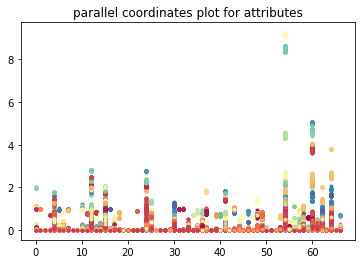

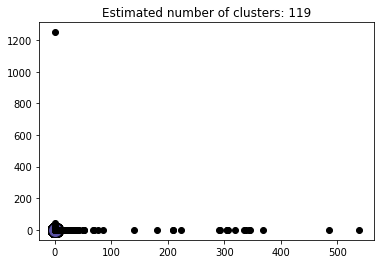

In [5]:
# This one for pca data.
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
xs = np.reshape(np.arange(dataset.shape[1]), (dataset.shape[1], 1))
print(xs.shape)
for idx, pt in enumerate(dataset[:cutoff]):
#     print(pt[pt > 0].shape)
    col = [0, 0, 0, 1] if labels[idx] == -1 else colors[labels[idx]]
    if labels[idx] <= 0 or pt[pt > 0].shape[0] <= 0:
        continue
    xs = np.where(pt > 0)
    new_xs = np.reshape(xs[0], (xs[0].shape[0], 1))
#     new_xs = np.array(list(zip(*xs)))[:, 1]
    plt.plot(new_xs, pt[pt > 0].T, '.', color=col)
plt.title('parallel coordinates plot for attributes')

plt.figure()
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = dataset[:cutoff][class_member_mask & core_samples_mask] # need todense because otherwise is wrong datatype to plot
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = dataset[:cutoff][class_member_mask & ~core_samples_mask] # need todense because otherwise is wrong datatype to plot
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

(67, 1)


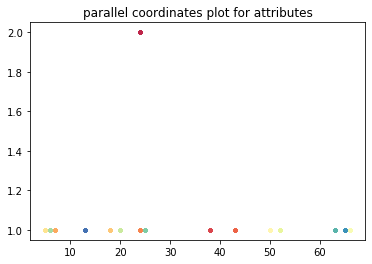

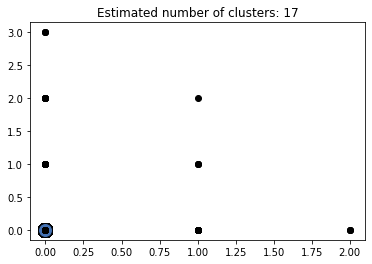

In [92]:
dataset = dataset
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
xs = np.reshape(np.arange(dataset.shape[1]), (dataset.shape[1], 1))
print(xs.shape)
for idx, pt in enumerate(dataset[:cutoff]):
#     print(pt[pt > 0].shape)
    col = [0, 0, 0, 1] if labels[idx] == -1 else colors[labels[idx]]
    if labels[idx] <= 0 or pt[pt > 0].shape[0] <= 0:
        continue
    xs = np.where(pt.T > 0)
    new_xs = np.reshape(xs[0], (xs[0].shape[0], 1))
# #     new_xs = np.array(list(zip(*xs)))[:, 1]
    plt.plot(new_xs, pt[pt > 0].T, '.', color=col)
plt.title('parallel coordinates plot for attributes')

plt.figure()
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = dataset[:cutoff][class_member_mask & core_samples_mask] # need todense because otherwise is wrong datatype to plot
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = dataset[:cutoff][class_member_mask & ~core_samples_mask] # need todense because otherwise is wrong datatype to plot
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [36]:
xy.shape

(32103, 67)

In [7]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(xnew)
distances, indices = nbrs.kneighbors(xnew)
print(distances, indices)

[[0.         2.82842712]
 [0.         1.        ]
 [0.         2.44948974]
 ...
 [0.         0.        ]
 [0.         2.        ]
 [0.         1.73205081]] [[     0 114751]
 [     1 100060]
 [     2  48230]
 ...
 [  1173   1508]
 [159569   2921]
 [159570  20804]]


Text(0.5, 1.0, 'Finding the optimal value for epsilon by 2 nearest neighbors')

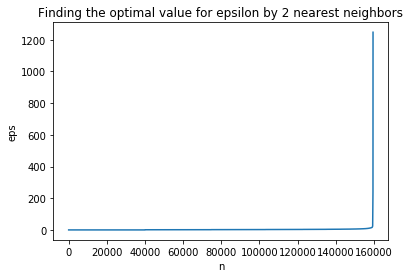

In [8]:
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.figure()
plt.plot(distances)
plt.xlabel('n')
plt.ylabel('eps')
plt.title('Finding the optimal value for epsilon by 2 nearest neighbors')

Text(0.5, 1.0, 'Finding the optimal value for epsilon by 2 nearest neighbors')

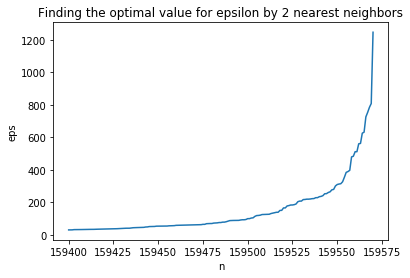

In [13]:
new_dist = distances[159400:]
plt.figure()
plt.plot(np.arange(159400, xnew.shape[0]), new_dist)
plt.xlabel('n')
plt.ylabel('eps')
plt.title('Finding the optimal value for epsilon by 2 nearest neighbors')